## 6 - Интегральная модель

### 6.1 - Библиотеки

In [1]:
import pandas as pd
import numpy as np

from _utils.model_test_functions import (roc, struct_Gini, gini_dynamic, HHI)
from _utils.text_preporation import (master_scale, reverse_scale)

from sklearn.metrics import roc_auc_score

import yaml

import warnings
warnings.filterwarnings("ignore")

### 6.2 - Пути

In [2]:
with open('../CONFIGS.yaml', 'r') as file:
    CONFIG = yaml.safe_load(file)

PATHS = CONFIG['data_paths']

In [3]:
filepath = {
      'clean_data'             : PATHS['other']['clean_data']
    , 'base_model_predictions' : PATHS['model_base']['predictions']
    , 'gov_influence'          : PATHS['module_gov']['influence']
    , 'group_influence'        : PATHS['module_group']['influence']
    , 'warning_signals'        : PATHS['module_warnings']['final']
    , 'warnings_raw'  : PATHS['module_warnings']['raw_data']
    , 'rating_weights': PATHS['ratings']['weights']
    , 'master_scale'  : PATHS['ratings']['master_scale']
    , 'predictions'   : PATHS['model_integral']['predictions']['raw']
}

### 6.3 - Данные

In [4]:
df_main         = pd.read_parquet(filepath['clean_data'])
base_model_pred = pd.read_parquet(filepath['base_model_predictions'])
gov_df          = pd.read_parquet(filepath['gov_influence'])
group_df        = pd.read_parquet(filepath['group_influence'])
signal_df       = pd.read_parquet(filepath['warning_signals'])
weight          = pd.read_parquet(filepath['rating_weights'])

warnings = pd.read_excel(filepath['warnings_raw'])
warnings = warnings.rename(columns = {'Код интеграции': 'signal', 'Ухудшение рейтинга': 'current_rating'})
warnings = warnings[['signal', 'current_rating']]
warnings['signal_type']  = np.where(warnings['current_rating'] < 17, 'additive', 'target')

master = pd.read_excel(filepath['master_scale'])
master.rename(columns = { 'Рейтинг':'rating'
                        , 'Нижний предел':'lower_bound'
                        , 'Вероятность Дефолта': 'pd'
                        , 'Верхний предел':'upper_bound' }, inplace=True)

### 6.4 - Определение переменных-помощников

In [5]:
target_col = 'target'
weight_col = 'W_norm'

id_cols = ['client_id', 'rating_id', weight_col, target_col]

TTC = CONFIG['calibration_params']['central_tendency']['TTC']
PIT = CONFIG['calibration_params']['central_tendency']['PIT']

### 6.5 - Формирование датасета

#### 6.5.1 - Датасет весов

In [6]:
weight = weight[['rating_id', weight_col]]

#### 6.5.2 - Датасет пред. сигналов

In [7]:
warnings_cols_to_drop = ['kws13', 'kws15', 'DT0300', 'DT1100', 'DT0100']
warnings = warnings.query('signal not in @warnings_cols_to_drop')
warnings = warnings.drop_duplicates()

#### 6.5.3 - Объединение данных

In [8]:
data = pd.merge(df_main,
                weight,
                how = 'inner',
                on = ['rating_id'])


data = pd.merge(data,
                base_model_pred,
                how = 'left',
                on = id_cols)


data = pd.merge(data,
                gov_df,
                how = 'left',
                on = ['rating_id'])

data = pd.merge(data,
                group_df,
                how = 'inner',
                on = ['rating_id'])

### 6.6 - Ограничение лучшего рейтинга 

In [9]:
data_1 = data.copy()
# Применяем страновой CAP
# Применение ограничений по лучшему рейтингу
data_1['base_model_ratings'] = np.where(data_1['base_model_ratings'] < 8, 8, data_1['base_model_ratings'])
data_1['PDg'] = np.where(data_1['PDg'] < 8, 8, data_1['PDg'])
data_1['gov_rating'] = np.where(data_1['gov_rating'] < 8, 8, data_1['gov_rating'])
# Заполнение пропусков
data_1['PDg'].fillna(8, inplace = True) 
data_1['gov_rating'].fillna(8, inplace = True)
# Обратное преобразование в вероятности
data_1['PDg_prob'] = data_1['PDg'].apply(lambda x: reverse_scale(x, master))
data_1['gov_prob'] = data_1['gov_rating'].apply(lambda x: reverse_scale(x, master))
data_1.head(10)

,bin,client_id,rating_id,rating_preliminary,rating_final,rating_assignment_date,target,survive,in_portfolio,segment_first_entry_date_when_healthy,...,qualitative_logits,base_model_preds,base_model_ratings,kgs_sum,gov_Wgr,gov_rating,PDg,Wgr,PDg_prob,gov_prob
0,100740010845,176783,1737,19,19.0,2018-12-12,0,1,1,2018-02-01,...,-3.253874,0.058878,18,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
1,31040000999,197185,1048,23,23.0,2018-08-14,0,1,1,2018-02-01,...,-2.308750,0.141180,21,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
2,80740006642,197255,912,25,25.0,2018-07-30,0,1,1,2018-07-01,...,-1.740931,0.218188,22,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
3,80740006642,197255,1734,24,24.0,2018-12-19,0,1,1,2018-07-01,...,-1.740931,0.218188,22,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
4,80740006642,197255,2254,24,24.0,2019-04-08,0,1,1,2018-07-01,...,-1.740931,0.123849,20,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
5,80740006642,197255,3170,20,20.0,2019-10-11,0,1,1,2018-07-01,...,-3.253874,0.055079,18,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
6,80740006642,197255,3588,17,17.0,2019-12-09,0,1,1,2018-07-01,...,-2.723362,0.058917,18,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
7,80740006642,197255,4669,23,23.0,2020-08-06,0,1,1,2018-07-01,...,0.092654,0.392588,24,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
8,80740006642,197255,4831,19,19.0,2020-08-28,0,1,1,2018-07-01,...,-0.858735,0.227033,22,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253
9,80740006642,197255,6287,19,19.0,2021-04-19,0,1,1,2018-07-01,...,-0.858735,0.227033,22,0.0,0.0,8.0,8.0,0.0,0.00253,0.00253


### 6.7 - Применение модулей групповой и государственной поддержки - расчет скорректированного базового рейтинга

In [10]:
data_2 = data_1.copy()

data_2['PDgr']  = data_2['Wgr'] * data_2['PDg_prob'] + (1 - data_2['Wgr']) * data_2['base_model_preds']
data_2['_PDgr'] = data_2['gov_Wgr'] * data_2['gov_prob'] + (1 - data_2['gov_Wgr']) * data_2['PDgr']

data_2['PDgg'] = data_2['_PDgr'].apply(lambda x: master_scale(x, master))
data_2['PDgg'] = np.where(data_2['PDgg'] < 8, 8, data_2['PDgg'])

# new_rating= base_model_ratings_adj
# new_pred = base_model_preds_adj
data_2['base_model_ratings_adj'] = data_2['base_model_preds'].apply(lambda x: master_scale(x, master))
data_2['base_model_ratings_adj'] = np.where(data_2['base_model_ratings_adj'] < 8, 8, data_2['PDgg'])
data_2['base_model_ratings_adj'] = np.where(data_2['base_model_ratings'] > data_2['PDgg'], data_2['PDgg'], data_2['base_model_ratings'])
data_2['base_model_preds_adj'] = data_2['base_model_ratings_adj'].apply(lambda x: reverse_scale(x, master))

### 6.8 - Применение сигналов - расчет интегрального рейтинга

In [11]:

cols = [  'client_id', 'rating_id', 'rating_assignment_date'
        , target_col , weight_col
        , 'quantitative_preds'    , 'qualitative_preds'
        , 'quantitative_logits'   , 'qualitative_logits'
        , 'base_model_preds'      , 'base_model_ratings'
        , 'base_model_ratings_adj', 'base_model_preds_adj' ]

data_3 = pd.merge(data_2[cols],
                 signal_df,
                 how = 'left',
                 on = ['client_id', 'rating_id'])

data_3.head()

,client_id,rating_id,rating_assignment_date,target,W_norm,quantitative_preds,qualitative_preds,quantitative_logits,qualitative_logits,base_model_preds,...,DT0700_3,DT0700_4,DT0700_5,DT0700_6,DT0700_7,DT0700_8,DT0700_9,DT0700_10,DT0900,DT1000
0,176783,1737,2018-12-12,0,2.843321,0.093473,0.037188,-2.271949,-3.253874,0.058878,...,0,0,0,0,0,0,0,0,0,0
1,197185,1048,2018-08-14,0,2.365725,0.116082,0.090401,-2.030063,-2.308750,0.141180,...,0,0,0,0,0,0,0,0,0,0
2,197255,912,2018-07-30,0,1.014112,0.124282,0.149195,-1.952490,-1.740931,0.218188,...,0,0,0,0,0,0,0,0,0,0
3,197255,1734,2018-12-19,0,0.767105,0.124282,0.149195,-1.952490,-1.740931,0.218188,...,0,0,0,0,0,0,0,0,0,0
4,197255,2254,2019-04-08,0,1.239054,0.054492,0.149195,-2.853659,-1.740931,0.123849,...,0,0,0,0,0,0,0,0,0,0


In [12]:
additive_columns = warnings.query('signal_type == "additive"')['signal'].tolist()
target_columns   = warnings.query('signal_type == "target"')['signal'].tolist() # сразу выкидывает на определенный рейтинг

additive = warnings.query('signal_type == "additive"')[['signal', 'current_rating']] \
                   .set_index(['signal'])['current_rating'] \
                   .to_dict()

target = warnings.query('signal_type == "target"')[['signal', 'current_rating']] \
                 .set_index(['signal'])['current_rating'] \
                 .to_dict()

for column in additive_columns:
    data_3[column] = data_3[column].replace(1, additive[column])
    
for column in target_columns:
    data_3[column] = data_3[column].replace(1, target[column])
    
data_3['additive_rules'] = data_3[additive_columns].max(axis=1)
data_3['target_rules']   = data_3[target_columns].max(axis = 1)
data_3 = data_3.drop(columns = additive_columns+target_columns)

# _new_rating = integral_model_ratings
# _new_pred = integral_model_preds
data_3['integral_model_ratings'] = data_3['base_model_ratings_adj'] + data_3['additive_rules']
data_3.loc[data_3['integral_model_ratings'] > 25, 'integral_model_ratings'] = 25
data_3.loc[data_3['integral_model_ratings'] < data_3['target_rules'], 'integral_model_ratings'] = data_3['target_rules']
data_3['integral_model_preds'] = data_3['integral_model_ratings'].apply(lambda x: reverse_scale(x, master))

data_3.head()

,client_id,rating_id,rating_assignment_date,target,W_norm,quantitative_preds,qualitative_preds,quantitative_logits,qualitative_logits,base_model_preds,base_model_ratings,base_model_ratings_adj,base_model_preds_adj,additive_rules,target_rules,integral_model_ratings,integral_model_preds
0,176783,1737,2018-12-12,0,2.843321,0.093473,0.037188,-2.271949,-3.253874,0.058878,18,18,0.06204,0,0,18,0.06204
1,197185,1048,2018-08-14,0,2.365725,0.116082,0.090401,-2.030063,-2.308750,0.141180,21,21,0.16203,0,0,21,0.16203
2,197255,912,2018-07-30,0,1.014112,0.124282,0.149195,-1.952490,-1.740931,0.218188,22,22,0.22313,0,0,22,0.22313
3,197255,1734,2018-12-19,0,0.767105,0.124282,0.149195,-1.952490,-1.740931,0.218188,22,22,0.22313,0,0,22,0.22313
4,197255,2254,2019-04-08,0,1.239054,0.054492,0.149195,-2.853659,-1.740931,0.123849,20,20,0.11765,0,0,20,0.11765


### 6.9 - Прирост Gini от каждого модуля

In [19]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Вычисление ROC AUC scores
a = roc_auc_score(data_3['target'], data_3['quantitative_preds']) * 100
b = roc_auc_score(data_3['target'], data_3['qualitative_preds']) * 100
c = roc_auc_score(data_3['target'], data_3['base_model_preds']) * 100
d = roc_auc_score(data_3['target'], data_3['base_model_preds_adj']) * 100
e = roc_auc_score(data_3['target'], data_3['integral_model_preds']) * 100

# Преобразование данных
gini = [2*x - 100 for x in [a, b, c, d, e]]
group_growth = gini[3] - gini[2]
signal_growth = gini[4] - gini[3]

# Классификация
growths = [gini[i] - gini[i-1] for i in range(1, len(gini))]

if any(growth < -5 for growth in growths):
    result = 'Красный'
elif all(growth > 0 for growth in growths):
    result = 'Зеленый'
else:
    result = 'Желтый'

# Вывод таблицы
print("=" * 60)
print("АНАЛИЗ Прироста GINI")
print("=" * 60)

print(f"{'Показатель':<45} {'Значение':<15} {'Прирост':<15}")
print("-" * 60)

labels = [
    'Количественный модуль',
    'Качественный модуль', 
    'Колич. + Кач. модули',
    'Корректировка группой и гос. поддержкой',
    'Корректировка пред. сигналами'
]

for i, (label, value) in enumerate(zip(labels, gini)):
    if i == 0:
        print(f"{label:<45} {value:>8.1f}% {'':<15}")
    elif i == 1:
        growth = value - gini[0]
        print(f"{label:<45} {value:>8.1f}% {growth:>+8.1f}%")
    elif i == 2:
        growth = value - gini[1]
        print(f"{label:<45} {value:>8.1f}% {growth:>+8.1f}%")
    elif i == 3:
        print(f"{label:<45} {value:>8.1f}% {group_growth:>+8.1f}%")
    else:
        print(f"{label:<45} {value:>8.1f}% {signal_growth:>+8.1f}%")

АНАЛИЗ Прироста GINI
Показатель                                    Значение        Прирост        
------------------------------------------------------------
Количественный модуль                             49.0%                
Качественный модуль                               56.4%     +7.5%
Колич. + Кач. модули                              64.5%     +8.1%
Корректировка группой и гос. поддержкой           64.8%     +0.3%
Корректировка пред. сигналами                     66.2%     +1.3%


### 6.10 - Дополнительная визуализация

Зеленый


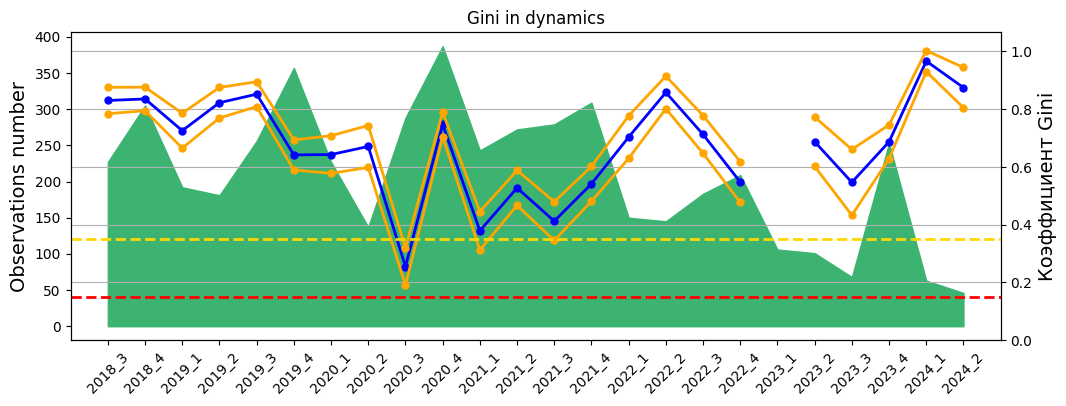

In [20]:
# Информативный, т.к. мало наблюдений
ss = gini_dynamic(data_3, 'target', 'integral_model_preds', 'rating_assignment_date', 1, 1, False, 'quarter')

График не отображает Gini за период 2023Q1, так как не было дефолтов. 

In [21]:
temp = data_3.copy()
temp['year']  = temp['rating_assignment_date'].dt.year
temp['quarter']  = temp['rating_assignment_date'].dt.quarter
temp = temp.groupby(['year', 'quarter'])['target'].agg(['count', 'mean'])
temp['dr>0'] = temp['mean']>0
temp

count      mean   dr>0
year quarter                        
2018 3          227  0.026432   True
     4          305  0.039344   True
2019 1          192  0.031250   True
     2          181  0.038674   True
     3          256  0.066406   True
     4          357  0.064426   True
2020 1          227  0.092511   True
     2          137  0.029197   True
     3          288  0.024306   True
     4          387  0.020672   True
2021 1          243  0.020576   True
     2          272  0.022059   True
     3          279  0.078853   True
     4          309  0.071197   True
2022 1          150  0.080000   True
     2          145  0.158621   True
     3          183  0.054645   True
     4          209  0.043062   True
2023 1          106  0.000000  False
     2          101  0.049505   True
     3           68  0.058824   True
     4          253  0.059289   True
2024 1           63  0.047619   True
     2           46  0.043478   True

Минимальный возможный рейтинг: 8
Максимально возможный рейтинг: 26


np.float64(0.04200323861396596)

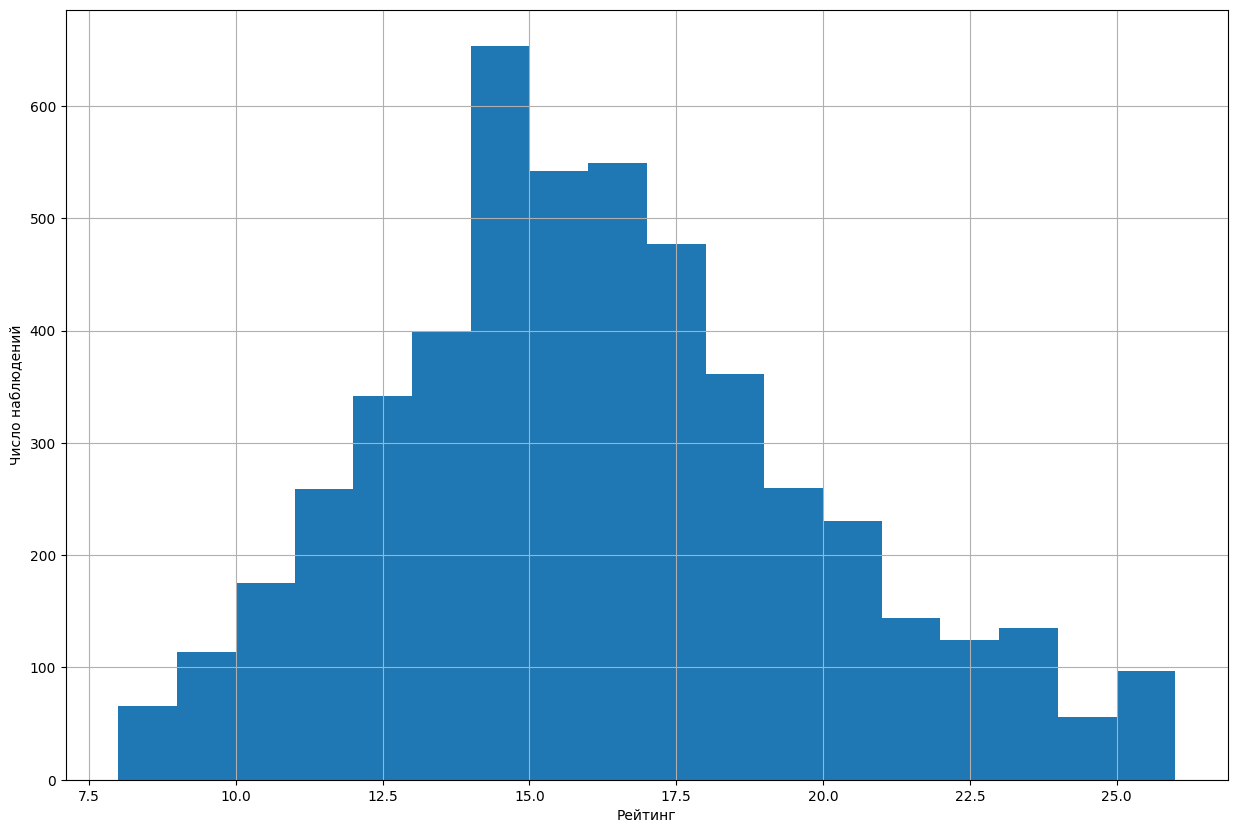

In [22]:
HHI(data_3['integral_model_ratings'], j = 26)

### 6.11 Сохранение данных

In [23]:
data_final = data_3.copy()

In [24]:
data_final[['client_id', 'rating_id', target_col, weight_col, 'rating_assignment_date', 'base_model_preds_adj', 'base_model_ratings_adj',  'integral_model_preds', 'integral_model_ratings']] \
    .to_parquet(filepath['predictions'])